In [1]:
import torch
from torch import nn

torch.__version__

'1.12.1'

In [2]:
device = torch.device("mps")
device

device(type='mps')

### Get Data
* The data we're going to be using is a subset of the Food101 dataset.
* Food101 is popular computer vision benchmark as it contains 1000 images of 101 different kinds of foods, totaling 101,000 images (75,750 train and 25,250 test).
* Can you think of 101 different foods?
* Can you think of a computer program to classify 101 foods?
* Instead of 101 food classes though, we're going to start with 3: pizza, steak and sushi.
* And instead of 1,000 images per class, we're going to start with a random 10% (start small, increase when necessary).
* Original dataset: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.


pizza_steak_sushi/ <- overall dataset folder
    train/ <- training images
        pizza/ <- class name as folder name
            image01.jpeg
            image02.jpeg
            ...
        steak/
            image24.jpeg
            image25.jpeg
            ...
        sushi/
            image37.jpeg
            ...
    test/ <- testing images
        pizza/
            image101.jpeg
            image102.jpeg
            ...
        steak/
            image154.jpeg
            image155.jpeg
            ...
        sushi/
            image167.jpeg
            ...

!!!! The goal will be to take this data storage structure and turn it into a dataset usable with PyTorch.

In [4]:
import os
def walk_through_dir(dir_path):
    """
      Walks through dir_path returning its contents.
      Args:
        dir_path (str or pathlib.Path): target directory
  
      Returns:
        A print out of:
          number of subdiretories in dir_path
          number of images (files) in each subdirectory
          name of each subdirectory
      """

    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 1 images in 'data/pizza_steak_sushi'.
There are 3 directories and 1 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


In [6]:
# Setup train and testing paths 
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Random image path: data/pizza_steak_sushi/test/sushi/1742201.jpg
Image class: sushi
Image height: 512
Image width: 512


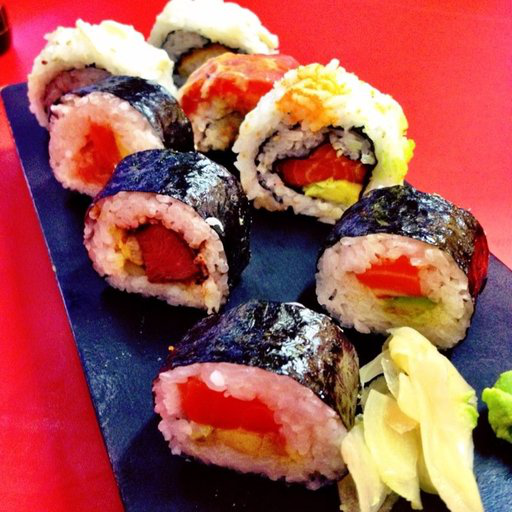

In [7]:
import random
from PIL import Image

# random.seed(42)

# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Pick a random image path
random_image_path = random.choice(image_path_list)

# Get image class from path name(the image class is name of the directory where the image is stored!)
image_class = random_image_path.parent.stem

# Open Image
img = Image.open(random_image_path)


# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 511.5, -0.5)

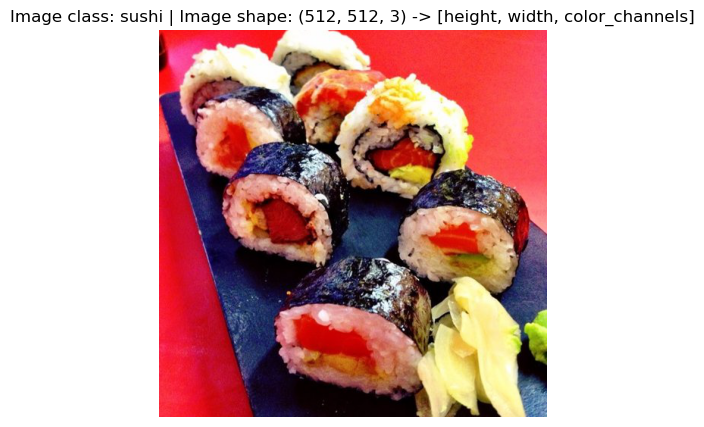

In [8]:
# Try to visualize and image with matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Turn image to an array
img_as_array = np.asarray(img)

# Plot image with matplotlib
plt.figure(figsize=(5 ,7))
plt.imshow(img_as_array)

plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

In [9]:
img_as_array # Our image is numerical!

array([[[255,  17,  15],
        [252,  20,  16],
        [249,  26,  19],
        ...,
        [251,  56,  98],
        [249,  54,  96],
        [255,  61, 105]],

       [[254,  21,  17],
        [250,  23,  17],
        [247,  26,  18],
        ...,
        [252,  57,  97],
        [249,  54,  96],
        [255,  61, 105]],

       [[249,  21,  20],
        [245,  23,  20],
        [239,  24,  19],
        ...,
        [253,  58,  98],
        [249,  54,  96],
        [255,  61, 105]],

       ...,

       [[253,  47,  70],
        [255,  51,  74],
        [255,  49,  72],
        ...,
        [110, 151, 183],
        [108, 149, 179],
        [ 91, 132, 160]],

       [[245,  39,  62],
        [244,  38,  61],
        [248,  42,  65],
        ...,
        [103, 144, 174],
        [100, 141, 169],
        [113, 157, 182]],

       [[248,  42,  65],
        [243,  37,  60],
        [251,  45,  68],
        ...,
        [126, 167, 197],
        [ 99, 143, 170],
        [114, 158, 183]]

Now what if we wanted to load our image data into PyTorch?

Before we can use our image data with PyTorch we need to:

* Turn it into tensors (numerical representations of our images).
* Turn it into a torch.utils.data.Dataset and subsequently a torch.utils.data.DataLoader, we'll call these Dataset and DataLoader for short.

In [10]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### Trasnforming data with torchvision.transforms
We've got folders of images but before we can use them with PyTorch, we need to convert them into tensors.

One of the ways we can do this is by using the torchvision.transforms module.

torchvision.transforms contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for data augmentation (the practice of altering data to make it harder for a model to learn, we'll see this later on) purposes .

To get experience with torchvision.transforms, let's write a series of transform steps that:

* Resize the images using transforms.Resize() (from about 512x512 to 64x64, the same shape as the images on the CNN Explainer website).
* Flip our images randomly on the horizontal using transforms.RandomHorizontalFlip() (this could be considered a form of data augmentation because it will artificially change our image data).
* Turn our images from a PIL image to a PyTorch tensor using transforms.ToTensor().

!! We can compile all of these steps using torchvision.transforms.Compose().

In [11]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our image 64*64
    transforms.Resize((64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn images into the tensor
    transforms.ToTensor()
])

In [12]:
# ERROR: img should be PIL Image. Got <class 'numpy.ndarray'>
# data_transform(img_as_array) 

In [13]:
data_transform(img) # Nicee

tensor([[[0.9843, 0.9843, 0.9882,  ..., 0.9882, 0.9765, 0.8902],
         [0.9804, 0.9843, 0.9882,  ..., 0.9843, 0.9529, 0.6667],
         [0.9843, 0.9843, 0.9882,  ..., 0.9804, 0.9176, 0.5137],
         ...,
         [0.4157, 0.3804, 0.3294,  ..., 0.9804, 0.9804, 0.9804],
         [0.4039, 0.3647, 0.3490,  ..., 0.9804, 0.9804, 0.9804],
         [0.4157, 0.3490, 0.3216,  ..., 0.9843, 0.9843, 0.9843]],

        [[0.2275, 0.2314, 0.2275,  ..., 0.0980, 0.0863, 0.0745],
         [0.2392, 0.2471, 0.2431,  ..., 0.1294, 0.1137, 0.0431],
         [0.2745, 0.2706, 0.2745,  ..., 0.1725, 0.1294, 0.0392],
         ...,
         [0.5608, 0.5451, 0.4980,  ..., 0.1608, 0.1765, 0.1725],
         [0.5451, 0.5255, 0.5294,  ..., 0.1412, 0.1647, 0.1725],
         [0.5569, 0.5059, 0.4941,  ..., 0.1412, 0.1686, 0.1804]],

        [[0.3608, 0.3176, 0.2627,  ..., 0.1059, 0.1020, 0.0745],
         [0.3686, 0.3412, 0.3059,  ..., 0.1569, 0.1294, 0.0510],
         [0.3922, 0.3647, 0.3373,  ..., 0.2824, 0.1804, 0.

In [14]:
data_transform(img).shape

torch.Size([3, 64, 64])

In [15]:
data_transform(img).dtype

torch.float32

### Visualising Transformed Images

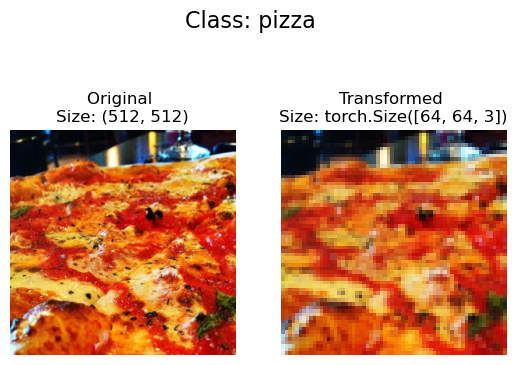

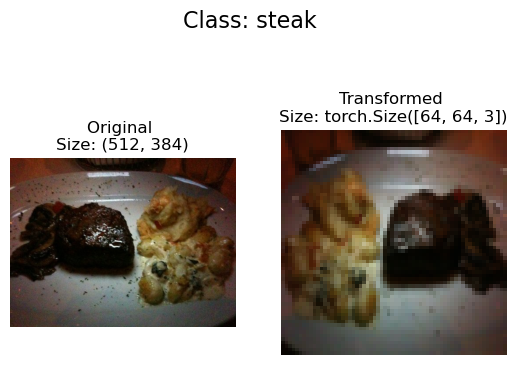

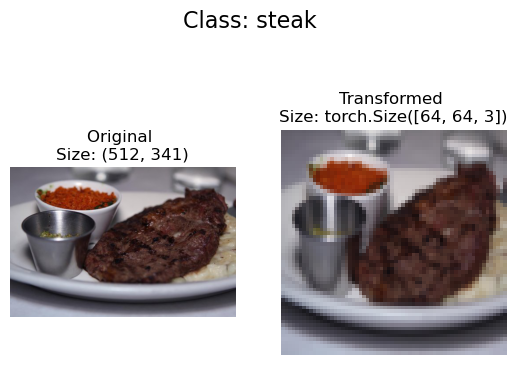

In [16]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

* We've now got a way to convert our images to tensors using torchvision.transforms.

* We also manipulate their size and orientation if needed (some models prefer images of different sizes and shapes).

* Generally, the larger the shape of the image, the more information a model can recover.

* For example, an image of size [256, 256, 3] will have 16x more pixels than an image of size [64, 64, 3] ((256*256*3)/(64*64*3)=16).

* However, the tradeoff is that more pixels requires more computations.

### Option 1: Loading Image Data Using `ImageFolder`

Alright, time to turn our image data into a Dataset capable of being used with PyTorch.

Since our data is in standard image classification format, we can use the class torchvision.datasets.ImageFolder.

Where we can pass it the file path of a target image directory as well as a series of transforms we'd like to perform on our images.

Let's test it out on our data folders train_dir and test_dir passing in transform=data_transform to turn our images into tensors.

In [17]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # Transform for the data
                                  target_transform=None) # Transform for the label
test_data = datasets.ImageFolder(root=test_dir,
                                transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [18]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [19]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [20]:
len(train_data), len(test_data)

(225, 75)

In [21]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [22]:
train_data[0] # Image pizze (label 0 bak aşağıda)

(tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
          [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
          [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
          ...,
          [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
          [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
          [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],
 
         [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
          [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
          [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
          ...,
          [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
          [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
          [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],
 
         [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
          [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
          [0.0902, 0.0902, 0.0902,  ...,

In [23]:
# How about our images and labels?
# How do they look?
img, label = train_data[0][0], train_data[0][1]
img

tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0157, 0.0157, 0.

In [24]:
label, class_names[label]

(0, 'pizza')

In [25]:
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Label datatype: {type(label)}")

Image shape: torch.Size([3, 64, 64])
Image datatype: torch.float32
Label datatype: <class 'int'>


Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


"\n\n\nNotice the image is now more pixelated (less quality).\n\nThis is due to it being resized from 512x512 to 64x64 pixels.\n\nThe intuition here is that if you think the image is harder to recognize what's going on, \nchances are a model will find it harder to understand too.\n\n"

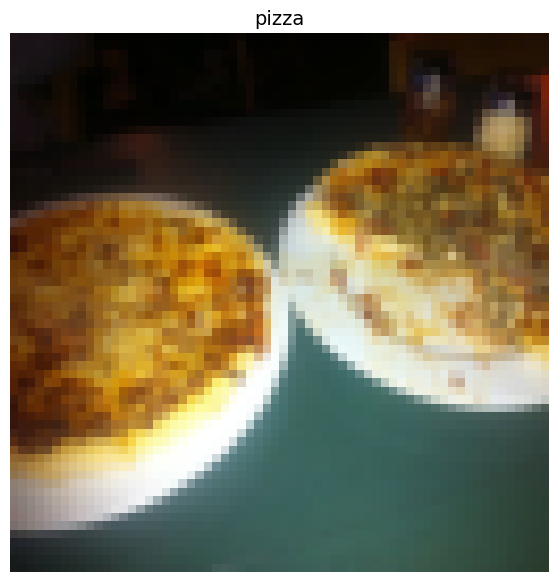

In [26]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);


"""


Notice the image is now more pixelated (less quality).

This is due to it being resized from 512x512 to 64x64 pixels.

The intuition here is that if you think the image is harder to recognize what's going on, 
chances are a model will find it harder to understand too.

"""

### Turn loaded images into DataLoader's

https://pytorch.org/docs/stable/data.html
* We've got our images as PyTorch Dataset's but now let's turn them into DataLoader's.
* We'll do so using torch.utils.data.DataLoader.
* Turning our Dataset's into DataLoader's makes them iterable so a model can go through learn the relationships between samples and targets (features and labels).

* To keep things simple, we'll use a batch_size=1 and num_workers=1.

* What's num_workers?
It defines how many subprocesses will be created to load your data.
Think of it like this, the higher value num_workers is set to, the more compute power PyTorch will use to load your data.

* Personally, I usually set it to the total number of CPUs on my machine via Python's os.cpu_count(). This ensures the DataLoader recruits as many cores as possible to load data.

In [27]:
os.cpu_count()

8

In [28]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1, # os.cpu_count() MAX
                              shuffle=True) 

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=1, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1393395d0>,
 <torch.utils.data.dataloader.DataLoader at 0x139338d90>)

In [29]:
len(train_dataloader), len(test_dataloader) # 225/32 = 7.03125  75/32=2.34375

(8, 3)

In [30]:
len(train_data), len(test_data)

(225, 75)

In [31]:
# İmage lar DataLoader da nasıl gözüküyor?
img, label = next(iter(train_dataloader))

print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")   # batchsize, color_channels, height, width
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[[0.3098, 0.3059, 0.3333,  ..., 0.3922, 0.3647, 0.3412],
          [0.3176, 0.4000, 0.3608,  ..., 0.3882, 0.3059, 0.2980],
          [0.3529, 0.4667, 0.4980,  ..., 0.3608, 0.3176, 0.3843],
          ...,
          [0.2314, 0.2353, 0.2235,  ..., 0.0784, 0.0784, 0.0706],
          [0.0706, 0.0706, 0.0706,  ..., 0.0549, 0.0510, 0.0471],
          [0.0235, 0.0235, 0.0235,  ..., 0.0549, 0.0588, 0.0588]],

         [[0.1961, 0.1922, 0.2000,  ..., 0.1804, 0.1686, 0.1451],
          [0.2078, 0.2941, 0.2431,  ..., 0.1804, 0.1333, 0.1255],
          [0.2314, 0.3529, 0.3804,  ..., 0.1686, 0.1373, 0.1608],
          ...,
          [0.1294, 0.1255, 0.1176,  ..., 0.0392, 0.0353, 0.0314],
          [0.0314, 0.0314, 0.0314,  ..., 0.0235, 0.0235, 0.0235],
          [0.0118, 0.0118, 0.0157,  ..., 0.0275, 0.0275, 0.0275]],

         [[0.1059, 0.1020, 0.0980,  ..., 0.0863, 0.0784, 0.0863],
          [0.1098, 0.1922, 0.1529,  ..., 0.0902, 0.0745, 0.0706],
          [0.1059, 0.2275, 0

## Option2: Loading Image Data with a Custom `Dataset`
* Want to be able to load images from file
* Want to be able to get class names from the Dataset
* Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to Pytorch pre-built `Dataset`functions

Cons:
* Even though you could create `Dataset` out of almost everything, it doesn't mean it will work.
* Using a custom `Dataset`often results in us writing more code, which could be prone to errors or perfromence issues.

In [32]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

from typing import Dict, Tuple, List

In [33]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx 

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Creating a helper function to get class names
- Yukarıdakini yapacak bir fonksiyon yazalım
Let's write a helper function capable of creating a list of class names and a dictionary of class names and their indexes given a directory path.

To do so, we'll:

* Get the class names using os.scandir() to traverse a target directory (ideally the directory is in standard image classification format).
* Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
* Turn the class names into a dictionary of numerical labels, one for each class.

In [34]:
# Setup path for target directory
target_directory = train_dir # PosixPath('data/pizza_steak_sushi/train')
print(f"Target dir: {target_directory}")

# list(os.scandir(target_directory)): [<DirEntry 'steak'>, <DirEntry 'sushi'>, <DirEntry 'pizza'>]
# Get class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [35]:
def find_classes(directory: str)-> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}....")
    
    class_to_idx = {class_name:  i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [36]:
find_classes(target_directory) # Nice!!!!

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## Create a custom Dataset to replicate ImageFolder
We'll build one to replicate the functionality of torchvision.datasets.ImageFolder().

This will be good practice, plus, it'll reveal a few of the required steps to make your own custom Dataset.

It'll be a fair bit of a code... but nothing we can't handle!

Let's break it down:

* Subclass torch.utils.data.Dataset.
* Initialize our subclass with a targ_dir parameter (the target data directory) and transform parameter (so we have the option to transform our data if needed).
* Create several attributes for paths (the paths of our target images), transform (the transforms we might like to use, this can be None), classes and class_to_idx (from our find_classes() function).
* Create a function to load images from file and return them, this could be using PIL or torchvision.io (for input/output of vision data).
* Overwrite the __len__ method of torch.utils.data.Dataset to return the number of samples in the Dataset, this is recommended but not required. This is so you can call len(Dataset).
* Overwrite the __getitem__ method of torch.utils.data.Dataset to return a single sample from the Dataset, this is required.

In [37]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path) 
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

In [38]:
# Create Transform
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [39]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir, transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir, transform=test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x1392e9ed0>,
 <__main__.ImageFolderCustom at 0x1392eba90>)

In [40]:
# train_data, test_data orjinal ImageFolder dan geldi
# train_data_custom, test_data_custom benim kendi class ımdan

In [41]:
len(train_data), len(train_data_custom)

(225, 225)

In [42]:
len(test_data), len(test_data_custom)

(75, 75)

In [43]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [44]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [45]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


## Create a function to display random images

* Take in a Dataset and a number of other parameters such as classes (the names of our target classes), the number of images to display (n) and a random seed.
* To prevent the display getting out of hand, we'll cap n at 10 images.
* Set the random seed for reproducible plots (if seed is set).
* Get a list of random sample indexes (we can use Python's random.sample() for this) to plot.
* Setup a matplotlib plot.
* Loop through the random sample indexes found in step 4 and plot them with matplotlib.
* Make sure the sample images are of shape HWC (height, width, color channels) so we can plot them.

In [46]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

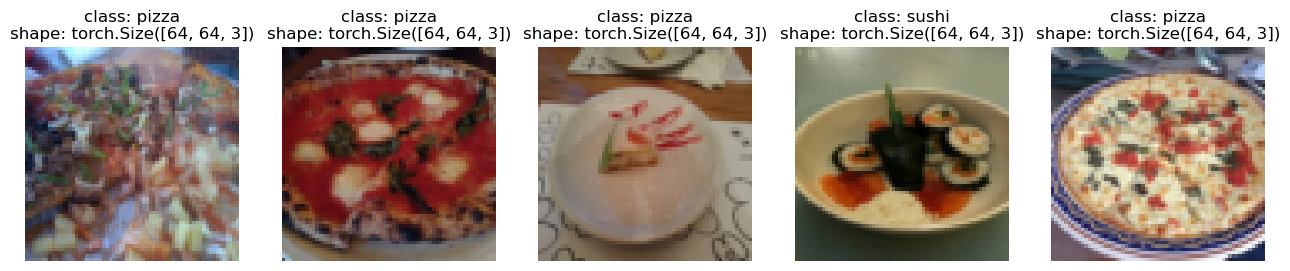

In [47]:
display_random_images(train_data, n=5, classes=class_names, seed=None)

## Turn custom loaded images into DataLoader's
We've got a way to turn our raw images into Dataset's (features mapped to labels or X's mapped to y's) through our ImageFolderCustom class.

Now how could we turn our custom Dataset's into DataLoader's?

If you guessed by using torch.utils.data.DataLoader(), you'd be right!

Because our custom Dataset's subclass torch.utils.data.Dataset, we can use them directly with torch.utils.data.DataLoader().

In [48]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=1, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x139299630>,
 <torch.utils.data.dataloader.DataLoader at 0x1393c67d0>)

In [49]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## Other forms of transforms (data augmentation)

Data augmentation is the process of altering your data in such a way that you artificially increase the diversity of your training set.

Training a model on this artificially altered dataset hopefully results in a model that is capable of better generalization (the patterns it learns are more robust to future unseen examples).

You can see many different examples of data augmentation performed on images using torchvision.transforms in PyTorch's Illustration of Transforms example.

#### https://pytorch.org/vision/main/transforms.html

<img src="dataaug.png" width="700" height="100">
Birçok türde transform var bunlar sadece örnek!

Makine öğrenimi tamamen rastgeleliğin gücünden yararlanmakla ilgilidir ve araştırmalar, rastgele dönüşümlerin (transforms.RandAugment() ve transforms.TrivialAugmentWide() gibi) genellikle elle seçilen dönüşümlerden daha iyi performans gösterdiğini göstermektedir!

Bir dizi dönüşümünüz var ve bir görüntü üzerinde ve belirli bir aralık arasında rastgele bir büyüklükte gerçekleştirmek için rastgele birkaçını seçersiniz (daha yüksek bir büyüklük daha yoğun anlamına gelir).

Kendi resimlerimizden bazılarında test etmeye ne dersiniz?

transforms.TrivialAugmentWide()'da dikkat edilmesi gereken ana parametre num_magnitude_bins=31'dir.

Belirli bir dönüşümü uygulamak için bir yoğunluk değerinin ne kadar aralığın seçileceğini tanımlar, 0 aralıksız ve 31 maksimum aralıktır (en yüksek yoğunluk için en yüksek şans).

In [50]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])


In [51]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1016217.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1285886.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/502076.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3424937.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/690177.jpg')]

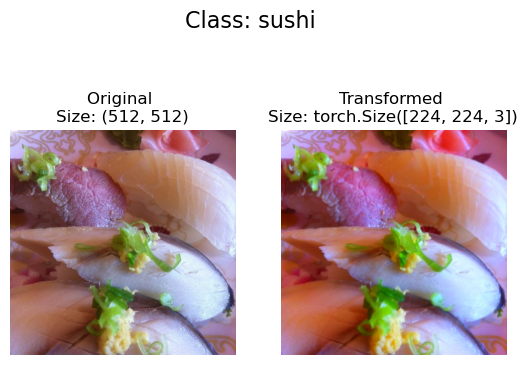

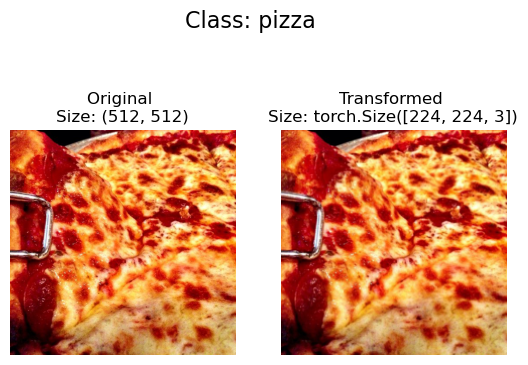

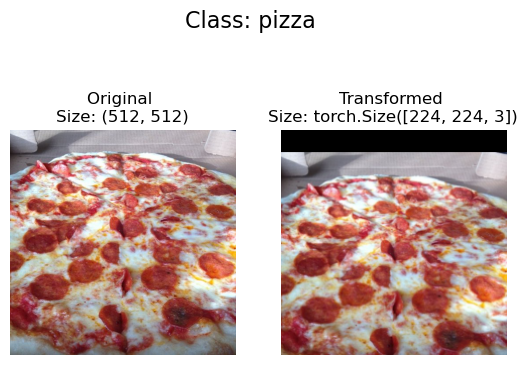

In [52]:
# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

# Model 0: TinyVGG without data augmentation

Alright, we've seen how to turn our data from images in folders to transformed tensors.

Now let's construct a computer vision model to see if we can classify if an image is of pizza, steak or sushi.

To begin, we'll start with a simple transform, only resizing the images to (64, 64) and turning them into tensors.

Let's replicate TinyVGG Architecture from the https://poloclub.github.io/cnn-explainer/

###  Creating transforms and loading data for Model 0

In [53]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [54]:
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                         transform=simple_transform)

# Turn the datasets to DataLoaders
BATCH_SIZE = 32
NUM_WORKERS= os.cpu_count()

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                     batch_size=BATCH_SIZE, 
                                     shuffle=False, 
                                     num_workers=NUM_WORKERS)


### Create TinyVGG model class

In [55]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self,
                 input_shape:int,
                 hidden_units:int,
                 output_shape:int
                )->None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=output_shape)
        )
        
    def forward(self, x):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        return x

In [56]:
torch.manual_seed(42)

model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(class_names)).to("cpu")
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

## Try a forward pass on a single image (to test the model)

A good way to test a model is to do a forward pass on a single piece of data.

It's also handy way to test the input and output shapes of our different layers.

To do a forward pass on a single image, let's:

* Get a batch of images and labels from the DataLoader.
* Get a single image from the batch and unsqueeze() the image so it has a batch size of 1 (so its shape fits the model).
* Perform inference on a single image (making sure to send the image to the target device).
* Print out what's happening and convert the model's raw output logits to prediction probabilities with torch.softmax() (since we're working with multi-class data) and convert the prediction probabilities to prediction labels with torch.argmax().

In [57]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [58]:
# Try a forward pass
# model_0(image_batch.to("cpu")) RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x1690 and 10x3)
# 32: batchsize     10:hidden units   1690 =! 10 YANI MATRIS ÇARPIMI HATASI
# 1690 = 10 * 13 * 13  (yani 16*16 ile çarp!!)

In [59]:
# Try a forward pass
model_0(image_batch.to("cpu"))

tensor([[ 2.0789e-02, -1.9351e-03,  9.5317e-03],
        [ 1.8427e-02,  2.4670e-03,  6.6757e-03],
        [ 1.7699e-02,  1.0262e-03,  9.4657e-03],
        [ 2.4441e-02, -3.3526e-03,  9.6011e-03],
        [ 1.9930e-02,  6.6315e-04,  1.0779e-02],
        [ 2.1281e-02,  2.0433e-03,  5.0046e-03],
        [ 2.0999e-02,  1.2868e-04,  1.2473e-02],
        [ 2.1577e-02, -1.9507e-03,  9.6941e-03],
        [ 2.4504e-02, -4.7745e-03,  8.5280e-03],
        [ 2.0252e-02, -4.7294e-04,  1.0908e-02],
        [ 2.2215e-02, -4.1835e-04,  9.8123e-03],
        [ 2.2313e-02, -2.1621e-03,  9.4455e-03],
        [ 2.1841e-02, -3.7132e-03,  8.3782e-03],
        [ 2.2863e-02, -1.7723e-03,  1.0287e-02],
        [ 2.1647e-02, -4.4139e-03,  9.5021e-03],
        [ 2.2096e-02, -4.1425e-03,  9.3853e-03],
        [ 2.1209e-02, -4.4219e-03,  1.1475e-02],
        [ 2.1711e-02, -2.7657e-03,  8.5006e-03],
        [ 1.9951e-02,  2.8320e-05,  8.4380e-03],
        [ 1.8298e-02,  1.6306e-03,  8.5499e-03],
        [ 2.0768e-02

##  Use torchinfo to get an idea of the shapes going through our model

In [60]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

##  Create train & test loop functions

In [61]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to("cpu"), y.to("cpu")

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [62]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to("cpu"), y.to("cpu")
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [63]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [64]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to("cpu")

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")
# UNDERFITTING!!!

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1063 | train_acc: 0.3047 | test_loss: 1.0983 | test_acc: 0.3116
Epoch: 2 | train_loss: 1.0995 | train_acc: 0.3320 | test_loss: 1.0699 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.0863 | train_acc: 0.4922 | test_loss: 1.0800 | test_acc: 0.5227
Epoch: 4 | train_loss: 1.0826 | train_acc: 0.4102 | test_loss: 1.0599 | test_acc: 0.5729
Epoch: 5 | train_loss: 1.0630 | train_acc: 0.4141 | test_loss: 1.0609 | test_acc: 0.5540
Total training time: 285.457 seconds


In [65]:
model_0_results

{'train_loss': [1.10634246468544,
  1.0994838327169418,
  1.0862896889448166,
  1.0826300084590912,
  1.0630110800266266],
 'train_acc': [0.3046875, 0.33203125, 0.4921875, 0.41015625, 0.4140625],
 'test_loss': [1.0983143250147502,
  1.0698522726694744,
  1.080026348431905,
  1.0598568121592205,
  1.060926874478658],
 'test_acc': [0.31155303030303033,
  0.5416666666666666,
  0.5227272727272728,
  0.5729166666666666,
  0.5539772727272728]}

##  Plot the loss curves of Model 0

In [66]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [67]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

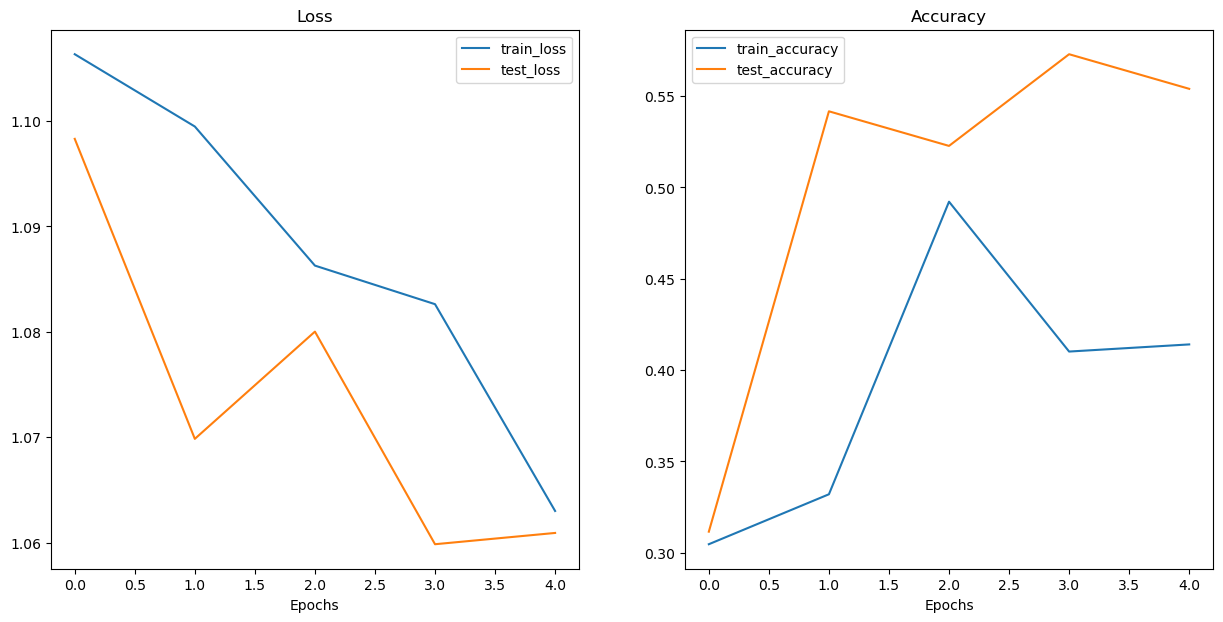

In [68]:
plot_loss_curves(model_0_results)


Looks like things are all over the place...

But we kind of knew that because our model's print out results during training didn't show much promise.

You could try training the model for longer and see what happens when you plot a loss curve over a longer time horizon.

## What should an ideal loss curve look like?

Looking at training and test loss curves is a great way to see if your model is overfitting.

An overfitting model is one that performs better (often by a considerable margin) on the training set than the validation/test set.

If your training loss is far lower than your test loss, your model is overfitting.

As in, it's learning the patterns in the training too well and those patterns aren't generalizing to the test data.

The other side is when your training and test loss are not as low as you'd like, this is considered underfitting.

The ideal position for a training and test loss curve is for them to line up closely with each other.

<img src="overfitting_underfitting.png" width="700" height="100">

## How to deal with overfitting

* Since the main problem with overfitting is that you're model is fitting the training data too well, you'll want to use techniques to "reign it in".

* A common technique of preventing overfitting is known as regularization.

* I like to think of this as "making our models more regular", as in, capable of fitting more kinds of data.

Let's discuss a few methods to prevent overfitting;

* `Get more data`: Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples.

* `Simplify your model`: If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer.

* `Use data augmentation`: Data augmentation manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data.

* `Use transfer learning`: Transfer learning involves leveraging the patterns (also called pretrained weights) one model has learned to use as the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images.

* `Use dropout layers`: Dropout layers randomly remove connections between hidden layers in neural networks, effectively simplifying a model but also making the remaining connections better. See torch.nn.Dropout() for more.

* `Use learning rate decay`: The idea here is to slowly decrease the learning rate as a model trains. This is akin to reaching for a coin at the back of a couch. The closer you get, the smaller your steps. The same with the learning rate, the closer you get to convergence, the smaller you'll want your weight updates to be.

* `Use early stopping`: Early stopping stops model training before it begins to overfit. As in, say the model's loss has stopped decreasing for the past 10 epochs (this number is arbitrary), you may want to stop the model training here and go with the model weights that had the lowest loss (10 epochs prior).

## How to deal with underfitting

* When a model is underfitting it is considered to have poor predictive power on the training and test sets.

* In essence, an underfitting model will fail to reduce the loss values to a desired level.

* Right now, looking at our current loss curves, I'd considered our TinyVGG model, model_0, to be underfitting the data.

* The main idea behind dealing with underfitting is to increase your model's predictive power.

Let's discuss a few methods to prevent overfitting;

* `Add more layers/units to your model`: If your model is underfitting, it may not have enough capability to learn the required patterns/weights/representations of the data to be predictive. One way to add more predictive power to your model is to increase the number of hidden layers/units within those layers.

* `Tweak the learning rate`: Perhaps your model's learning rate is too high to begin with. And it's trying to update its weights each epoch too much, in turn not learning anything. In this case, you might lower the learning rate and see what happens.

* `Use transfer learning`: Transfer learning is capable of preventing overfitting and underfitting. It involves using the patterns from a previously working model and adjusting them to your own problem.

* `Train for longer`: Sometimes a model just needs more time to learn representations of data. If you find in your smaller experiments your model isn't learning anything, perhaps leaving it train for a more epochs may result in better performance.

* `Use less regularization`: Perhaps your model is underfitting because you're trying to prevent overfitting too much. Holding back on regularization techniques can help your model fit the data better.

# Model 1: TinyVGG with Data Augmentation

In [69]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor() 
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [70]:
# Create train and test Dataset's and DataLoader's
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ))

In [71]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1393d6ce0>,
 <torch.utils.data.dataloader.DataLoader at 0x139338d90>)

In [72]:
# Construct and train Model 1
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to("cpu")
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [73]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_1
model_1_results = train(model=model_1, 
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1046 | train_acc: 0.2500 | test_loss: 1.1016 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0764 | train_acc: 0.4258 | test_loss: 1.1301 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0733 | train_acc: 0.4258 | test_loss: 1.1679 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1220 | train_acc: 0.3047 | test_loss: 1.1552 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0775 | train_acc: 0.4609 | test_loss: 1.1522 | test_acc: 0.2812
Total training time: 286.527 seconds


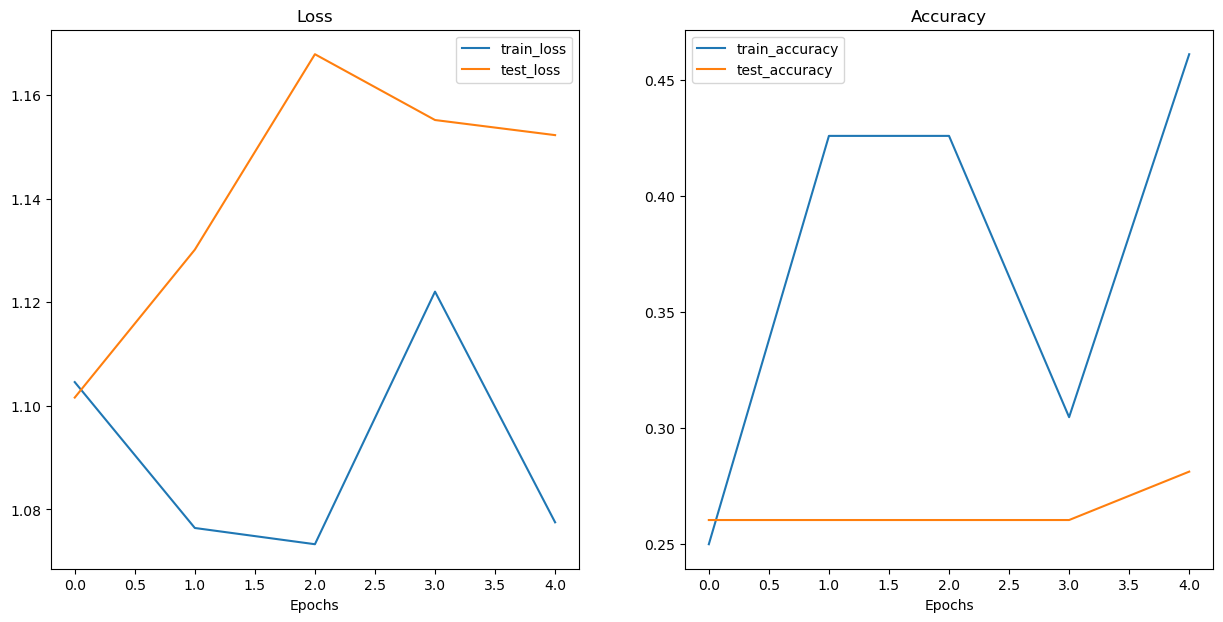

In [74]:
plot_loss_curves(model_1_results)

In [75]:
# Compare model results
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106342,0.304688,1.098314,0.311553
1,1.099484,0.332031,1.069852,0.541667
2,1.086290,0.492188,1.080026,0.522727
3,1.082630,0.410156,1.059857,0.572917
4,1.063011,0.414062,1.060927,0.553977


In [76]:
model_1_df

,train_loss,train_acc,test_loss,test_acc
0,1.104575,0.250000,1.101587,0.260417
1,1.076417,0.425781,1.130136,0.260417
2,1.073283,0.425781,1.167858,0.260417
3,1.122036,0.304688,1.155158,0.260417
4,1.077509,0.460938,1.152242,0.281250


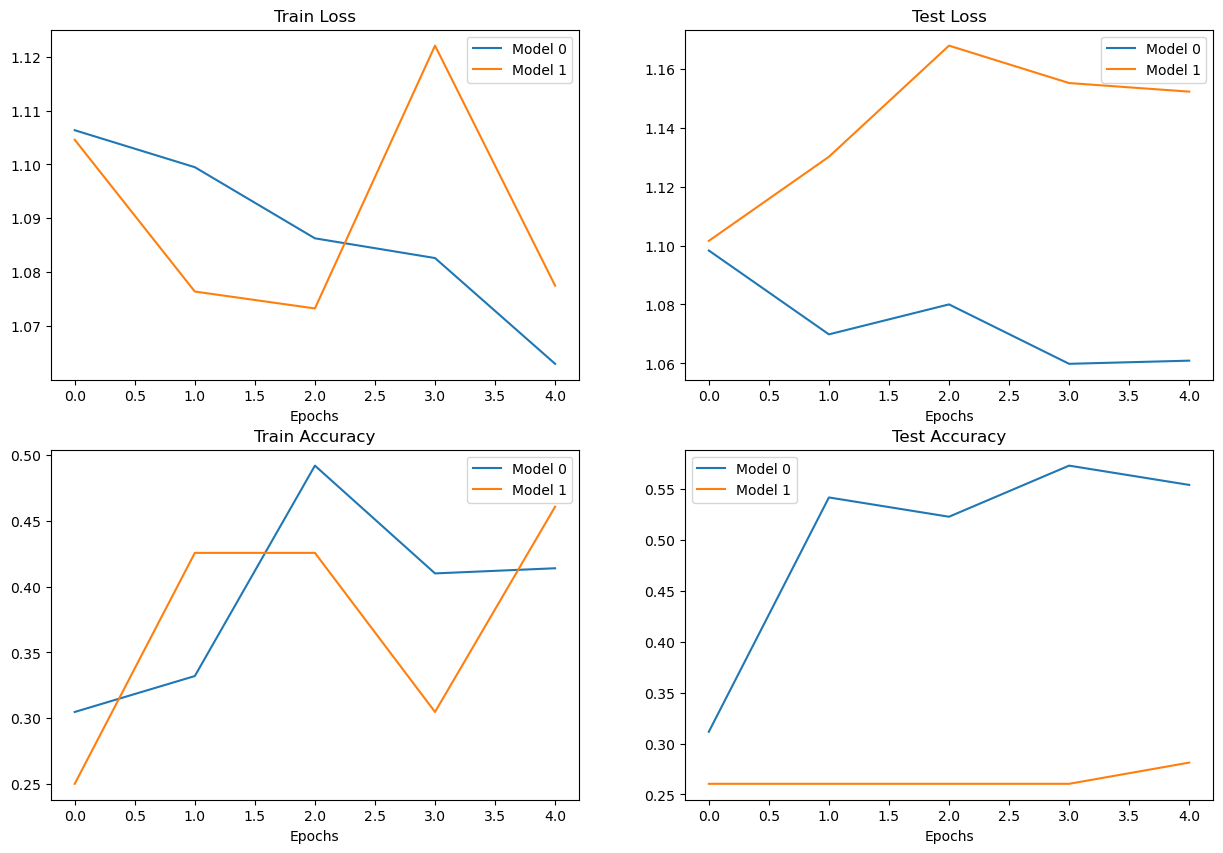

In [77]:
# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

## Make a prediction on a custom image

In [114]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "custom_img.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

data/custom_img.jpeg already exists, skipping download.


## Loading in a custom image with Pytorch
We have to make sure our custom image is in the same format as the data our model was trained on
* In tensor form with datatype(torch.float32)
* Of shape 64x64x3
* On the right device

In [115]:
import torchvision
# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
custom_image_uint8 # That is our image in int form!

tensor([[[153, 152, 149,  ...,  22,  18,  19],
         [143, 141, 137,  ...,   7,   9,  16],
         [137, 134, 130,  ...,   3,   6,  17],
         ...,
         [ 33,  67,  17,  ..., 163, 189, 186],
         [ 29,  67,  14,  ..., 104,  91,  64],
         [ 20,  31,  13,  ..., 110, 138, 118]],

        [[137, 136, 133,  ...,  25,  21,  22],
         [127, 125, 121,  ...,   8,  10,  17],
         [121, 118, 114,  ...,   3,   6,  17],
         ...,
         [ 29,  63,  13,  ..., 162, 188, 185],
         [ 25,  63,  10,  ..., 103,  90,  63],
         [ 16,  27,   9,  ..., 109, 137, 117]],

        [[121, 120, 117,  ...,  18,  14,  15],
         [111, 109, 105,  ...,   0,   2,   9],
         [106, 103,  99,  ...,   0,   0,   9],
         ...,
         [ 28,  62,  12,  ..., 160, 186, 183],
         [ 24,  62,   9,  ..., 101,  88,  61],
         [ 15,  26,   8,  ..., 107, 135, 115]]], dtype=torch.uint8)

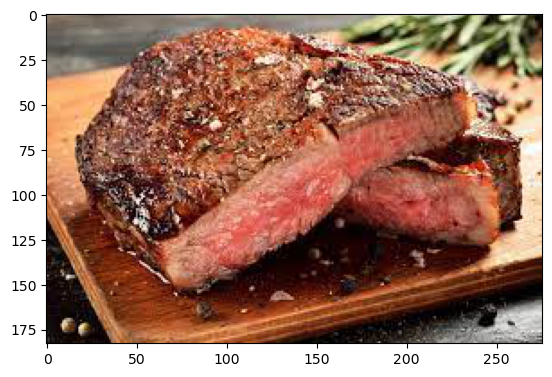

In [116]:
plt.imshow(custom_image_uint8.permute(1,2,0))

In [117]:
# Print out image data informations
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image shape: torch.Size([3, 183, 276])

Custom image dtype: torch.uint8


In [118]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255. 

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6000, 0.5961, 0.5843,  ..., 0.0863, 0.0706, 0.0745],
         [0.5608, 0.5529, 0.5373,  ..., 0.0275, 0.0353, 0.0627],
         [0.5373, 0.5255, 0.5098,  ..., 0.0118, 0.0235, 0.0667],
         ...,
         [0.1294, 0.2627, 0.0667,  ..., 0.6392, 0.7412, 0.7294],
         [0.1137, 0.2627, 0.0549,  ..., 0.4078, 0.3569, 0.2510],
         [0.0784, 0.1216, 0.0510,  ..., 0.4314, 0.5412, 0.4627]],

        [[0.5373, 0.5333, 0.5216,  ..., 0.0980, 0.0824, 0.0863],
         [0.4980, 0.4902, 0.4745,  ..., 0.0314, 0.0392, 0.0667],
         [0.4745, 0.4627, 0.4471,  ..., 0.0118, 0.0235, 0.0667],
         ...,
         [0.1137, 0.2471, 0.0510,  ..., 0.6353, 0.7373, 0.7255],
         [0.0980, 0.2471, 0.0392,  ..., 0.4039, 0.3529, 0.2471],
         [0.0627, 0.1059, 0.0353,  ..., 0.4275, 0.5373, 0.4588]],

        [[0.4745, 0.4706, 0.4588,  ..., 0.0706, 0.0549, 0.0588],
         [0.4353, 0.4275, 0.4118,  ..., 0.0000, 0.0078, 0.0353],
         [0.4157, 0.4039, 0.3882,  ..

In [119]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 183, 276])
New shape: torch.Size([3, 64, 64])


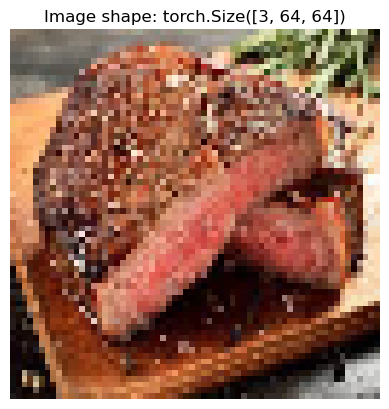

In [120]:
plt.imshow(custom_image_transformed.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image_transformed.shape}")
plt.axis(False);

In [121]:
# New shape: torch.Size([3, 64, 64]) Modelde batch dimension da var o nedenler bu şekilde modele koyarsan HATA!
# UNSQUEEZE ILE BOYUT EKLE
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to("cpu")) # model cpu üzerinde koşuyor
custom_image_pred

tensor([[ 0.0378,  0.0712, -0.2089]])

In [122]:
class_names

['pizza', 'steak', 'sushi']

In [123]:
# Convert logits to prediction probs
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.3552, 0.3673, 0.2775]])

In [124]:
# Convert to pred prob to labels
custom_image_pred_labels = torch.argmax(custom_image_pred_probs, dim=1).cpu()
custom_image_pred_labels

tensor([1])

In [125]:
class_names[custom_image_pred_labels]

'steak'

In [127]:
def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str, 
                        class_names: List[str] = None, 
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""
    
    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255. 
    
    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)
    
    # 4. Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
    
        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))
        
    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

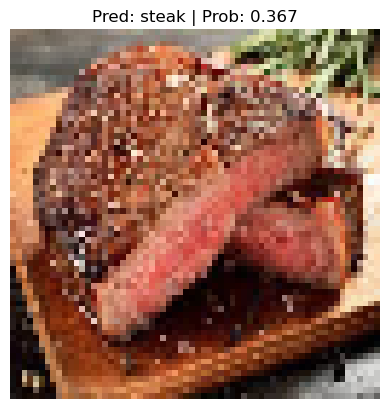

In [128]:
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device="cpu")